## Load libraries

In [24]:
from torch import nn
from torch import optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import time
from sklearn.metrics import confusion_matrix

## Define training and test sets

In [25]:
Type="TRAINING"
exec(open("../helperFunctions.py","rb").read())

Select classes to use for training:


Checkbox(value=False, description='Dogs', indent=False)

Checkbox(value=False, description='Cats', indent=False)

In [26]:
UsedClasses=[]
for k in widgetDict:
    if widgetDict[k].value==True:
        UsedClasses.append(k)
if(len(UsedClasses)<2):
    print("Something is wrong here. we need at least 2 classes!")

## Loading data set
If test set is not defined previously, this function pulls a test set from the training set using a 80/20%split

In [27]:
classes =  tuple(UsedClasses)

transform = transforms.Compose(
    [transforms.Resize(224),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainSets=[]
testSets=[]

for cl in classes:   
    trainPath=os.path.join(SPECTRUM_IMAGES_ROOT,cl,'train')
    if os.path.isdir (trainPath):
        trainSets.append(SpectrumDataset(classes.index(cl),trainPath,transform))
    else:
        print('Coud not find path',trainPath);
    
    testPath=os.path.join(SPECTRUM_IMAGES_ROOT,cl,'test')
    if os.path.isdir (testPath):
        testSets.append(SpectrumDataset(classes.index(cl),testPath,transform))
    else:
        print('Coud not find path',testPath);


lowestItemCount=np.inf
classID=None
for i,train in enumerate(trainSets):
    if(lowestItemCount>len(train)):
        lowestItemCount=len(train)
        classID=i
        lowestItemCount=len(train)
for i in range(len(trainSets)):
    trainSets[i].ReduceSize(lowestItemCount)
    

TrainDataSet = torch.utils.data.ConcatDataset(trainSets)
TestDataSet = torch.utils.data.ConcatDataset(testSets)

trainloader = torch.utils.data.DataLoader(TrainDataSet, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(TestDataSet, batch_size=16, shuffle=False)

../GeneratedData/Dogs/train 2042
../GeneratedData/Dogs/test 302
../GeneratedData/Cats/train 2526
../GeneratedData/Cats/test 375


## Preview sample training images

The following cell takes an entire training batch of images and displays them with their respective labels. Have a look and verify that indeed you see spectrograph images that look similar to what you saw earlier.

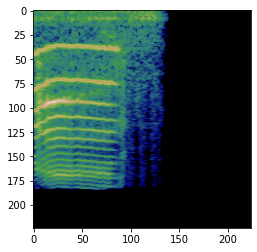

Cats


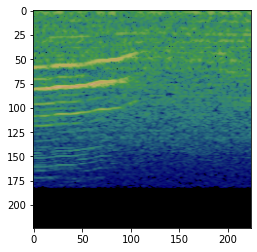

Cats


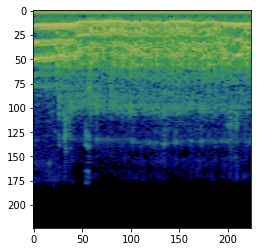

Cats


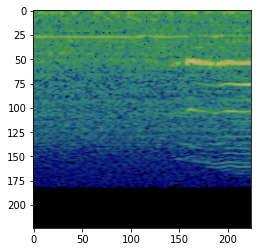

Cats


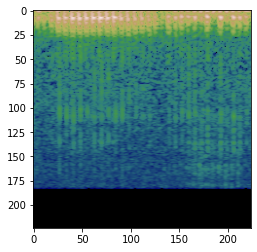

Cats


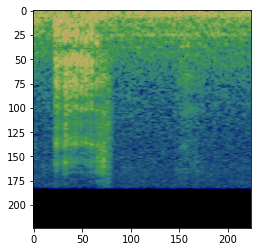

Cats


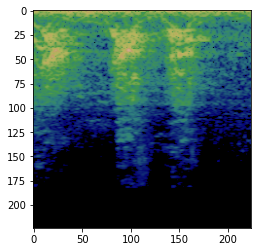

Dogs


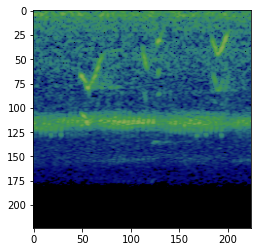

Dogs


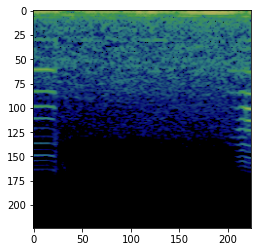

Cats


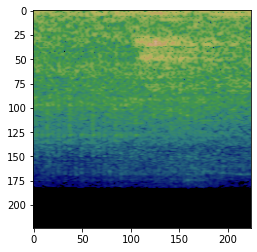

Dogs


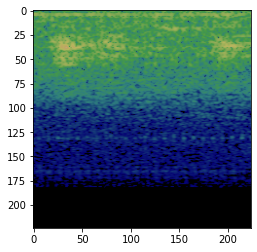

Cats


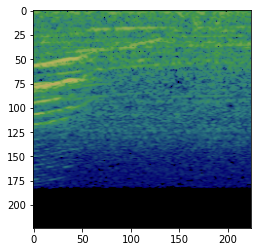

Cats


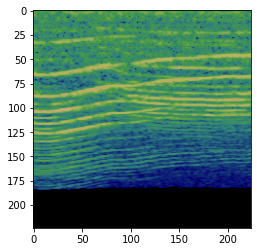

Cats


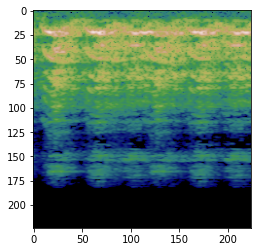

Dogs


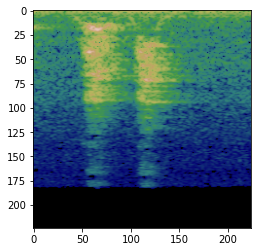

Dogs


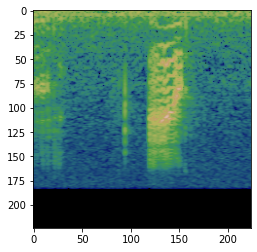

Cats


In [28]:
#Getting some random training images and showing them
dataiter = iter(trainloader)
images, labels = dataiter.next()
for i in range(trainloader.batch_size):
    imshow(images[i])
    print(classes[labels[i]])

## Specify use of Graphics Card (if there is one) and use ResNet

In [32]:
if torch.cuda.is_available():
    print("using gpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)


## Load pretrained model 
The model '../Models/MainModelUrban.pth' was trained on the UrbanSound dataset; other models could be specified instead.

In [33]:
ModelData = torch.load('../Models/MainModelUrban.pth',map_location='cpu')
model.load_state_dict(ModelData['model'])

<All keys matched successfully>

## Cutting off the head
In the following cell, the setting 'param.requires_grad = False' is **the** function that is telling the network to only retrain the last layer. If you set this parameter to True, the training will take much longer, but hopefully be better at predicting. 

In [34]:
'''
For each parameter in the network we turn of training, 
by setting  .requires_grad  to `False`.

This makes sure that the computer will not try to adjust thos variables when "training".
'''
for param in model.parameters(): #
    param.requires_grad = False #... 
    
'''
'fc' stands for "fully connected" and it is the very last layer in the neural net.
We replace this layer with a new fully connected layer, that connects the 512 input neurons to neurons for our classes.
'''    
model.fc = nn.Linear(512, len(classes)) 

## Move model to GPU (if there is a GPU)

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_epoch_losses=[]
test_epoch_losses=[]
epoch=0

In [36]:
model.fc = nn.Linear(512, len(classes)) 

## Training the network

In [37]:
#Training the network on the training dataset
for i in range(5):  # loop over the dataset multiple (5) times 
    epoch+=1
    print("Starting epoch:",epoch)
    epochLoss=0.0
    t0 = time.time()
    model.train()
    for i, data in enumerate(trainloader, 0):
        print("Running Batches",i)
        # get the inputs
        inputs, labels = data
        if device.type=='cuda':
            inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        if((i+i)%200==0):
            if(i>0):
                print('Processed images:',i*trainloader.batch_size,'. Running Timer @ {:.2f}sec.'.format(time.time()-t0))
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epochLoss+=loss.item()
        
    
    model.eval()
    testLoss=0
    print("About to test the performance on the test set.")
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            # get the inputs
            inputs, labels = data
            if device.type=='cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            testLoss+=loss.item()
            if(i%50==0):
                if(i>0):
                    print('Tested images:',i*testloader.batch_size,'. Running Timer @ {:.2f}sec.'.format(time.time()-t0))


    train_epoch_losses.append(epochLoss/len(trainloader))
    test_epoch_losses.append(testLoss/len(testloader))
    EpochLength = time.time()-t0
    print('{} train loss: {:.3f} and test loss: {:.3f}, and it took us: {:.2f} seconds.'.format (epoch + 1, epochLoss / len(trainloader),testLoss/len(testloader),EpochLength))  # DAVID CHanged it to 1000 from 2000 not sure if thats totally done
print('Finished Training')


Starting epoch: 1
Running Batches 0
Running Batches 1
Running Batches 2
Running Batches 3
Running Batches 4
Running Batches 5
Running Batches 6
Running Batches 7
Running Batches 8
Running Batches 9
Running Batches 10
Running Batches 11
Running Batches 12
Running Batches 13
Running Batches 14
Running Batches 15
Running Batches 16
Running Batches 17
Running Batches 18
Running Batches 19
Running Batches 20
Running Batches 21
Running Batches 22
Running Batches 23
Running Batches 24
Running Batches 25
Running Batches 26
Running Batches 27
Running Batches 28
Running Batches 29
Running Batches 30
Running Batches 31
Running Batches 32
Running Batches 33
Running Batches 34
Running Batches 35
Running Batches 36
Running Batches 37
Running Batches 38
Running Batches 39
Running Batches 40
Running Batches 41
Running Batches 42
Running Batches 43
Running Batches 44
Running Batches 45
Running Batches 46
Running Batches 47
Running Batches 48
Running Batches 49
Running Batches 50
Running Batches 51
Runn

Running Batches 149
Running Batches 150
Running Batches 151
Running Batches 152
Running Batches 153
Running Batches 154
Running Batches 155
Running Batches 156
Running Batches 157
Running Batches 158
Running Batches 159
Running Batches 160
Running Batches 161
Running Batches 162
Running Batches 163
Running Batches 164
Running Batches 165
Running Batches 166
Running Batches 167
Running Batches 168
Running Batches 169
Running Batches 170
Running Batches 171
Running Batches 172
Running Batches 173
Running Batches 174
Running Batches 175
Running Batches 176
Running Batches 177
Running Batches 178
Running Batches 179
Running Batches 180
Running Batches 181
Running Batches 182
Running Batches 183
Running Batches 184
Running Batches 185
Running Batches 186
Running Batches 187
Running Batches 188
Running Batches 189
Running Batches 190
Running Batches 191
Running Batches 192
Running Batches 193
Running Batches 194
Running Batches 195
Running Batches 196
Running Batches 197
Running Batches 198


Running Batches 33
Running Batches 34
Running Batches 35
Running Batches 36
Running Batches 37
Running Batches 38
Running Batches 39
Running Batches 40
Running Batches 41
Running Batches 42
Running Batches 43
Running Batches 44
Running Batches 45
Running Batches 46
Running Batches 47
Running Batches 48
Running Batches 49
Running Batches 50
Running Batches 51
Running Batches 52
Running Batches 53
Running Batches 54
Running Batches 55
Running Batches 56
Running Batches 57
Running Batches 58
Running Batches 59
Running Batches 60
Running Batches 61
Running Batches 62
Running Batches 63
Running Batches 64
Running Batches 65
Running Batches 66
Running Batches 67
Running Batches 68
Running Batches 69
Running Batches 70
Running Batches 71
Running Batches 72
Running Batches 73
Running Batches 74
Running Batches 75
Running Batches 76
Running Batches 77
Running Batches 78
Running Batches 79
Running Batches 80
Running Batches 81
Running Batches 82
Running Batches 83
Running Batches 84
Running Batc

Running Batches 181
Running Batches 182
Running Batches 183
Running Batches 184
Running Batches 185
Running Batches 186
Running Batches 187
Running Batches 188
Running Batches 189
Running Batches 190
Running Batches 191
Running Batches 192
Running Batches 193
Running Batches 194
Running Batches 195
Running Batches 196
Running Batches 197
Running Batches 198
Running Batches 199
Running Batches 200
Processed images: 3200 . Running Timer @ 628.68sec.
Running Batches 201
Running Batches 202
Running Batches 203
Running Batches 204
Running Batches 205
Running Batches 206
Running Batches 207
Running Batches 208
Running Batches 209
Running Batches 210
Running Batches 211
Running Batches 212
Running Batches 213
Running Batches 214
Running Batches 215
Running Batches 216
Running Batches 217
Running Batches 218
Running Batches 219
Running Batches 220
Running Batches 221
Running Batches 222
Running Batches 223
Running Batches 224
Running Batches 225
Running Batches 226
Running Batches 227
Running 

## Post training analytics

After the training has finished, save information about the training

In [39]:
# saving the learnd model in file that can be loaded in for inference
torch.save({
    'model':model.state_dict(),
    'classes':classes,
    'resolution':224,
    'modelType':"resnet18" # <= If you try out different models make sure to change this too
},"../models/CatDogResNet.pth") # <=Edit file name here 

Display how the traing and test loss progressed over successive epochs

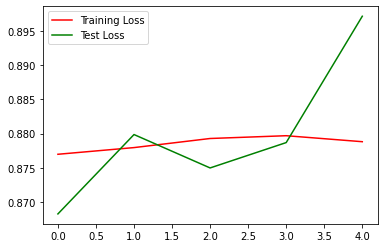

In [40]:
#Displaying how the loss progresses over time.
plt.plot(train_epoch_losses, label='Training Loss',c='r')
plt.plot(test_epoch_losses, label='Test Loss',c='g')
plt.legend()
plt.show()

Show spectagrams, Predicted and Actual labels.

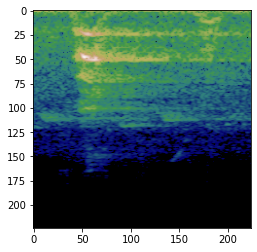

GroundTruth:  Dogs
Predicted:  Dogs


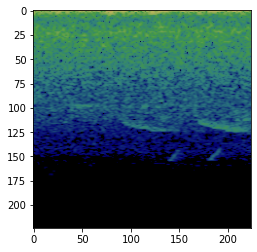

GroundTruth:  Dogs
Predicted:  Dogs


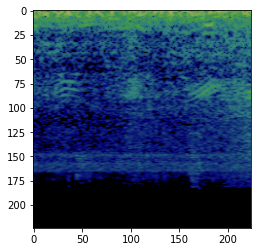

GroundTruth:  Dogs
Predicted:  Dogs


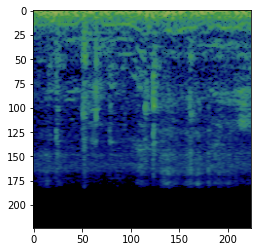

GroundTruth:  Dogs
Predicted:  Dogs


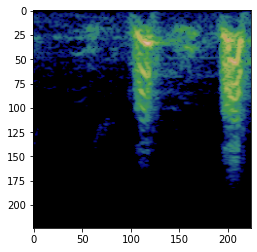

GroundTruth:  Dogs
Predicted:  Dogs


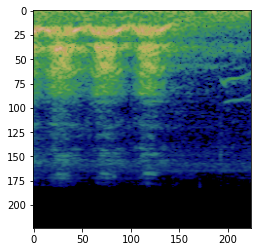

GroundTruth:  Dogs
Predicted:  Dogs


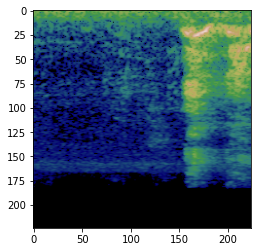

GroundTruth:  Dogs
Predicted:  Dogs


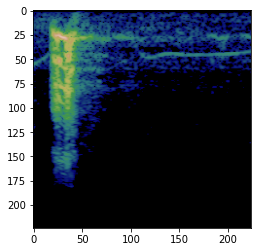

GroundTruth:  Dogs
Predicted:  Dogs


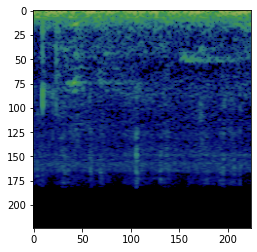

GroundTruth:  Dogs
Predicted:  Dogs


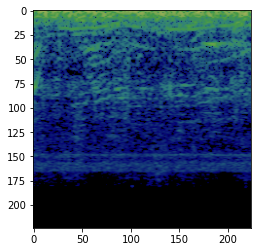

GroundTruth:  Dogs
Predicted:  Dogs


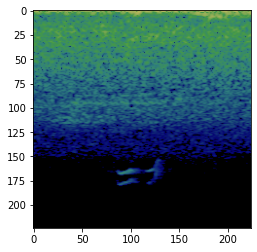

GroundTruth:  Dogs
Predicted:  Dogs


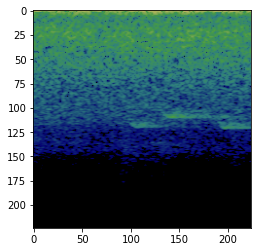

GroundTruth:  Dogs
Predicted:  Dogs


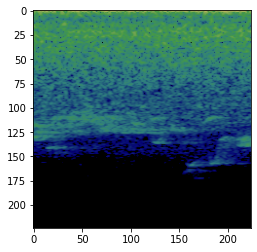

GroundTruth:  Dogs
Predicted:  Dogs


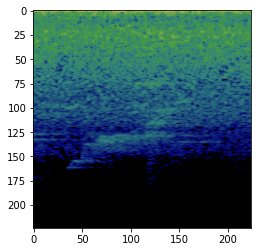

GroundTruth:  Dogs
Predicted:  Dogs


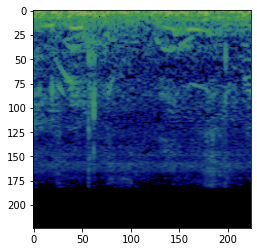

GroundTruth:  Dogs
Predicted:  Dogs


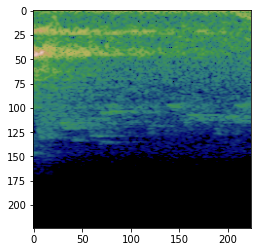

GroundTruth:  Dogs
Predicted:  Dogs


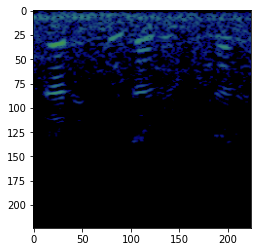

GroundTruth:  Dogs
Predicted:  Dogs


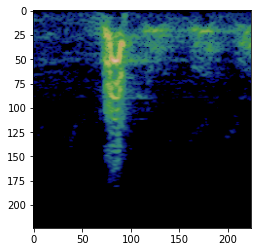

GroundTruth:  Dogs
Predicted:  Dogs


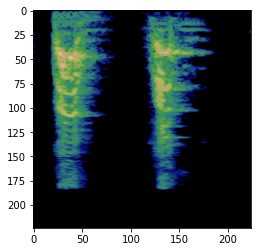

GroundTruth:  Dogs
Predicted:  Dogs


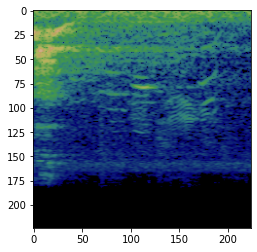

GroundTruth:  Dogs
Predicted:  Dogs


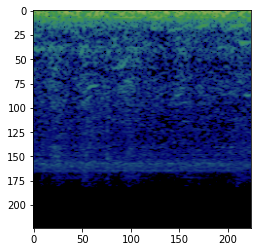

GroundTruth:  Dogs
Predicted:  Dogs


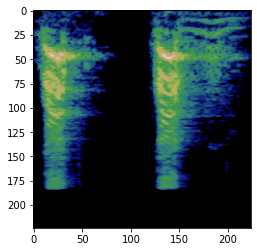

GroundTruth:  Dogs
Predicted:  Dogs


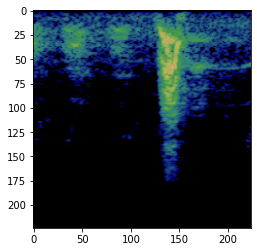

GroundTruth:  Dogs
Predicted:  Dogs


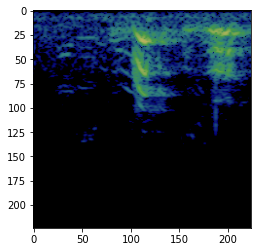

GroundTruth:  Dogs
Predicted:  Dogs


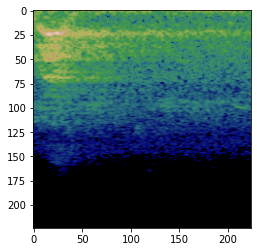

GroundTruth:  Dogs
Predicted:  Dogs


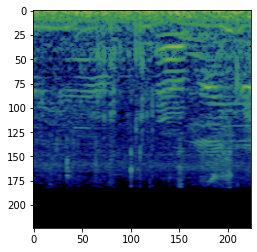

GroundTruth:  Dogs
Predicted:  Dogs


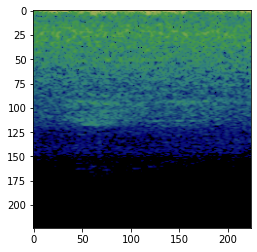

GroundTruth:  Dogs
Predicted:  Dogs


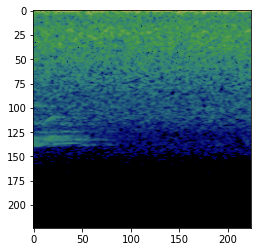

GroundTruth:  Dogs
Predicted:  Dogs


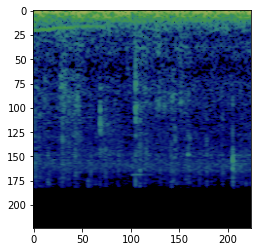

GroundTruth:  Dogs
Predicted:  Dogs


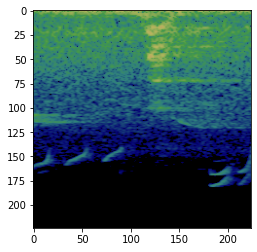

GroundTruth:  Dogs
Predicted:  Dogs


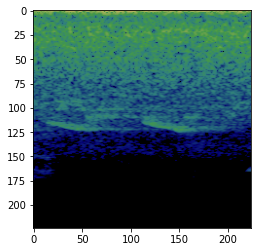

GroundTruth:  Dogs
Predicted:  Dogs


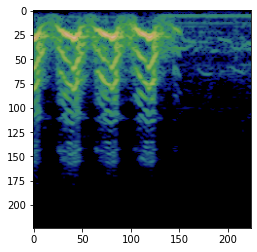

GroundTruth:  Dogs
Predicted:  Dogs


In [41]:
# Print predicted and acual labels for Spectragrams
dataiter = iter(testloader)
model.eval()
for j in range (2):
    images, labels = dataiter.next()
    if device == 'cuda':
        images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    for i in range(len(images)):
        imshow(images[i])
        print('GroundTruth: ',classes[labels[i]])
        print('Predicted: ',  classes[predicted[i]])


Print accuracy of test predictions for each label

In [16]:
# Network analytics
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
model.eval()
allLabels=[]
allPrediction=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if (c.dim()==0):
            continue
        for i in range(testloader.batch_size):
            if(len(labels)<=i):
                continue;
            label = labels[i]
            allLabels.append(labels[i].to('cpu').numpy())
            allPrediction.append(predicted[i].to('cpu').numpy())
            #print (c.shape)
            if(testloader.batch_size>1):

                class_correct[label] += c[i].item()
            else:
                class_correct[label] += c.item()
            class_total[label] += 1

print(confusion_matrix(allLabels, allPrediction))
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

[[ 62 155]
 [ 88 147]]
Accuracy of  cats : 28 %
Accuracy of  dogs : 62 %


5 Epoch:
[[2126 1362]
 [ 426 4373]]
Accuracy of  Dogs : 60 %
Accuracy of  Cats : 91 %